<a href="https://colab.research.google.com/github/sunwu2008/Coursera-ML-AndrewNg-Notes/blob/master/build_a_tiny_large_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Tiny Large Model from Scratch

A notebook that builds up the intuition behind Transformers, bit-by-bit, in [JAX](https://jax.readthedocs.io/en/latest/index.html) with [Penzai's](https://penzai.readthedocs.io/) named axes system. This notebook was developed for [CSC 2541H1: Large Models](https://www.cs.toronto.edu/~cmaddis/courses/csc2541_w25/) taught at UToronto by [Chris J. Maddison](https://www.cs.toronto.edu/~cmaddis/). It is inspired by Andrej Karpathy's [notebook](https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbllONmg3WW9NOS1GODA5VVN5Q0tuWGhsUmthQXxBQ3Jtc0trUU5pM0JtUjZrWThNSXRMVE1lZ3ZncXljSV95UjJseXZuTE50VEUwbFVIVDRYcmhnNzh0eHBGNEE2Yk9wTE05WEh0YkhYMmVsbXlieTBqenNNcFlTYW9Ha29pMHJJb0U3MnJDcG0zbVJCWGFicmV2Yw&q=https%3A%2F%2Fcolab.research.google.com%2Fdrive%2F1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-%3Fusp%3Dsharing&v=kCc8FmEb1nY).

* **Lecture:** [Lecture 1 of CSC 2541H1: Large Models](https://www.cs.toronto.edu/~cmaddis/courses/csc2541_w25/lectures/lec1.pdf) provides important context behind what we mean by prediction.

## Imports

*    We will be computing with [JAX](https://jax.readthedocs.io/en/latest/index.html), which is a high-performance array computing library for Python that implements automatic differentiation.
  * **If you haven't seen or used JAX before, you can think of it as Numpy with automatic differentiation functionality.**
*    We're using [Penzai](https://penzai.readthedocs.io/) and [Treescope](https://treescope.readthedocs.io/) for named axis functionality and pretty array printing, respectively. These libraries were written by [Daniel Johnson](https://www.danieldjohnson.com/), a UofT graduate student.

In [ ]:
import traceback
import numpy as np
import jax
import jax.numpy as jnp
try:
  from penzai import pz
except ImportError:
  !pip install penzai[notebook]
  from penzai import pz
import treescope
from penzai.core.named_axes import wrap, nmap
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import humanize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.8/317.8 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.1 MB/s eta 0:00:00


In [ ]:
# initialize the visualizer
treescope.basic_interactive_setup(autovisualize_arrays=True)

## Raw Text Data

Data starts as bits collected from the internet. In our case, we will be working with subsets of the [Tiny Stories](https://arxiv.org/abs/2305.07759) training and validation sets.
  *    Tiny Stories is a synthetic dataset of short stories that only contain words that a typical 3 to 4-year-olds usually understand, generated by GPT-3.5 and GPT-4.
  *    Tiny Stories comes with a training / validation split, but typically, if you're really starting from scratch, you will need to make your own split.

* Let's begin by downloading and inspecting the data.

In [ ]:
# Let's download the data and load it into memory
!wget -O train.txt https://www.cs.toronto.edu/~cmaddis/files/TinyStories-train-subset.txt
!wget -O valid.txt https://www.cs.toronto.edu/~cmaddis/files/TinyStories-valid-subset.txt

# this loads the data into memory, split into a list of stories (or documents)
with open('train.txt', 'r') as f:
  train = f.read()

with open('valid.txt', 'r') as f:
  val = f.read()

--2025-02-23 21:16:09--  https://www.cs.toronto.edu/~cmaddis/files/TinyStories-train-subset.txt
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1020038 (996K) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>] 996.13K  2.53MB/s    in 0.4s    

2025-02-23 21:16:09 (2.53 MB/s) - ‘train.txt’ saved [1020038/1020038]

--2025-02-23 21:16:10--  https://www.cs.toronto.edu/~cmaddis/files/TinyStories-valid-subset.txt
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114692 (112K) [text/plain]
Saving to: ‘valid.txt’

valid.txt           100%[===================>] 112.00K   592KB/s    in 0.2s    

2025-02-23 21:16:10 (592 KB/s) - ‘valid.txt’ saved [114692

In [ ]:
# strings are sequences of characters
print("length of training dataset in characters: ", humanize.intword(len(train)))
print("length of validation dataset in characters: ", humanize.intword(len(val)))

# each character represented in UTF-8 takes up (approx) 8 bits
print("\nlength of training dataset in bits (approx): ", humanize.intword(len(train)*8))
print("length of validation dataset in bits (approx): ", humanize.intword(len(val)*8))

length of training dataset in characters:  1.0 million
length of validation dataset in characters:  114.7 thousand

length of training dataset in bits (approx):  8.2 million
length of validation dataset in bits (approx):  917.5 thousand


In [ ]:
# let's look at the first story
first_story = train.split("<|endoftext|>")[0]
print(first_story)

One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.
Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."
Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.



* Our goal will be to build a tiny stories predictor
* The predictors that we've been studying are distributions over discrete outcomes. To build a distribution, you need to know the the complete set of possible outcomes
* **Our predictors will predict characters, one at a time, so we need to know the total set of characters**


In [ ]:
# here are all the unique characters that occur in this text
ALPHABET = sorted(list(set(train+val)))
ALPHABET_SIZE = len(ALPHABET)
print(f"There are {ALPHABET_SIZE} unique characters in this data set.")
print(f"Characters: {repr(''.join(ALPHABET))}")

There are 79 unique characters in this data set.
Characters: '\n !"$\',-.012358:;<>?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz|–—‘’“”'


## Tokenization

Predictors are defined, built, and studied using numbers. So, we need a numerical representation for text that allows us to build a predictor.

* Tokenizers are functions that take sequences of characters and convert them into sequences of numbers
* Tokenizers are invertible operations
* There are many different types of tokenizers, see, *e.g.*, [HuggingFace Tokenizers](https://huggingface.co/docs/tokenizers/en/index)
* We will be using the simplest tokenizer, which is a character-level tokenizer

When we build predictors, formally, they will be *token predictors*

* Character-level tokenization first creates a mapping from characters to integers
* Encoding strings now consists of iteratively mapping each character, in order
* Decoding is the reverse operation, iteratively mapping each integer to a character, according to the inverse map

In [ ]:
# create a mapping from characters to integers
ctoi = { ch:i for i,ch in enumerate(ALPHABET) }
itoc = { i:ch for i,ch in enumerate(ALPHABET) } # inverse map
ENCODE = lambda s: [ctoi[c] for c in s] # encoder: take a string, output a list of integers
DECODE = lambda l: ''.join([itoc[i] for i in l]) # decoder: take a list of integers, output a string

* Encoded strings are **sequences of tokens**

In [ ]:
string = "a tiny large model"
print(f"A string: {repr(string)}")
print(f"Its sequence of tokens: {ENCODE(string)}")
print(f"Encode & decode are inverses: {repr(DECODE(ENCODE(string)))}")

A string: 'a tiny large model'
Its sequence of tokens: [46, 1, 65, 54, 59, 70, 1, 57, 46, 63, 52, 50, 1, 58, 60, 49, 50, 57]
Encode & decode are inverses: 'a tiny large model'


* Let's encode the whole training and validation sets for convenience

In [ ]:
TRAIN_TOKENS = np.array(ENCODE(train), dtype=np.int32)
VAL_TOKENS = np.array(ENCODE(val), dtype=np.int32)
print(f"Train set has {TRAIN_TOKENS.shape[0]} tokens")
print("The story we looked at earlier, as will be seen by our predictor:")
print(TRAIN_TOKENS[:len(first_story+"<|endoftext|>")]) # the story we looked at earier

Train set has 1019132 tokens
The story we looked at earlier, as will be seen by our predictor:
[34 59 50  1 49 46 70  6  1 46  1 57 54 65 65 57 50  1 52 54 63 57  1 59
 46 58 50 49  1 31 54 57 70  1 51 60 66 59 49  1 46  1 59 50 50 49 57 50
  1 54 59  1 53 50 63  1 63 60 60 58  8  1 38 53 50  1 56 59 50 68  1 54
 65  1 68 46 64  1 49 54 51 51 54 48 66 57 65  1 65 60  1 61 57 46 70  1
 68 54 65 53  1 54 65  1 47 50 48 46 66 64 50  1 54 65  1 68 46 64  1 64
 53 46 63 61  8  1 31 54 57 70  1 68 46 59 65 50 49  1 65 60  1 64 53 46
 63 50  1 65 53 50  1 59 50 50 49 57 50  1 68 54 65 53  1 53 50 63  1 58
 60 58  6  1 64 60  1 64 53 50  1 48 60 66 57 49  1 64 50 68  1 46  1 47
 66 65 65 60 59  1 60 59  1 53 50 63  1 64 53 54 63 65  8  0 31 54 57 70
  1 68 50 59 65  1 65 60  1 53 50 63  1 58 60 58  1 46 59 49  1 64 46 54
 49  6  1  3 32 60 58  6  1 28  1 51 60 66 59 49  1 65 53 54 64  1 59 50
 50 49 57 50  8  1 22 46 59  1 70 60 66  1 64 53 46 63 50  1 54 65  1 68
 54 65 53  1 58 50  1 46 59 4

## Contexts and Batching

Our token predictors will be conditional predictors, using the language on Lec 1.

* There are a number of different conditional distributions that we could choose to model
* We will model a sequence of tokens given one initial token
* We can decompose distributions over many tokens into a sequence of next token conditional distributions, using what we know from probability. For example, if $x_i \in \mathbb{N}$ is a sequence of tokens, then

$$p(x_1, x_2, x_3 | x_0) = p(x_1 | x_0) p(x_2 | x_0, x_1)p(x_3 | x_0, x_1, x_2)$$

* For this reason, we focus on *next-token prediction*.


We predict the next token by conditioning on a *context window*, which is the sequence of tokens that just precede it.

* We would love to learn models with infinitely long context windows
* But the cost of computing predictors will scale with the context length
* So, in practice, we fix a maximum context length ahead of time and train predictors that condition on contexts of at most that length
* That is, if $T$ is the maximum context length and $x_0, \ldots, x_T$ is a random subsequence of the data, we want to model $p(x_1, \ldots, x_T | x_0)$, which we will do by modeling the sequence of next token conditionals using the following decomposition:

$$p(x_1, \ldots, x_T | x_0) = p(x_1 | x_0) p(x_2 | x_0, x_1)\ldots p(x_T | x_0, \ldots, x_{T-1})$$


Let's look at the first few context windows in our training set.

In [ ]:
max_context_len = 8
print(f"The first {max_context_len} context windows of the training set:")
for t in range(max_context_len):
  context = TRAIN_TOKENS[:t+1]
  print(f"The {humanize.ordinal(t+1)} context window of the training data is: {context}")

The first 8 context windows of the training set:


NameError: name 'TRAIN_TOKENS' is not defined

* The conditional predictors that we're studying are functions that map inputs to probability distributions
* We optimize their parameters so that the output distributions minimizes the cross entropy to the target outcomes
* In the case of next token prediction, the targets are the next tokens and the inputs are the context windows

In [ ]:
print('Recall: we want to model p(x[1:max_context_len+1]|x[0]).')
print('Recall: we will do this by modeling p(x[i]|x[0:i]) for i in range(1, max_context_len+1).\n')
print('Thus, returning to our data, we want to build predictors for each of the following prediction problems.')
max_context_len = 8
for t in range(max_context_len):
  x = TRAIN_TOKENS[:t+1]
  y = TRAIN_TOKENS[t+1]
  print(f"From the {humanize.ordinal(t+1)} context x={x} predict target y={y}")
print('We will train a predictor for each of these.')

* We can efficiently store all of the prediction problems into two arrays.
* Store the context windows into a single input array `X` and all of the next-token targets into a single output array `Y`.

In [ ]:
max_context_len = 8
X = TRAIN_TOKENS[:max_context_len]
Y = TRAIN_TOKENS[1:max_context_len+1]
print(f"Y={Y}\nX={X}")
print("Notice: X[:i] is the ith context window for i in range(1,max_context_len+1)")
print("Notice: X[:i]'s next token is at the index in Y[i]")

* To take advantage of GPU's parallel computation architecture, we will train on *batches* of data
* A batch of data is a sequence of (input, output) subsequences of the data
  * There are many different batching strategies
  * The choice of which batching strategy to use depends on your hardware constraints and statistical considerations
  * We will get them by randomly picking a position in the training set and pulling `max_context_len` subsequences representing the input and output
  * Recall: the output sequence is offset by 1 from the input sequence so that it represents the next tokens for every context window
* Let's write a batching function

In [ ]:
np.random.seed(2541)

def get_batch(batch_size, max_context_len, split):
  # generate a small batch of data of inputs x and targets y
  data = TRAIN_TOKENS if split == "train" else VAL_TOKENS
  ix = np.random.randint(0, len(data) - max_context_len, (batch_size,))
  X = np.stack([data[i:i+max_context_len] for i in ix])
  Y = np.stack([data[i+1:i+max_context_len+1] for i in ix])
  return X, Y

batch_size = 4 # how many independent sequences will we process in parallel?
max_context_len = 8 # what is the maximum context length for predictions?
XB, YB = get_batch(batch_size, max_context_len, "train")
print('inputs:')
print(XB.shape)
print(XB)
print('targets:')
print(YB.shape)
print(YB)
print('This is what the Transformer sees.')
print('We will learn predictors from the input to the output.')

## Penzai Named Arrays

We'll be using named arrays, which assign string names to axes. This is because named axes can make it easier to keep track of the various dimensions of the tensors in Transformer computations, and they allow us to focus on the axes in tensors that are "interacting".

To do this, we'll be using [Penzai](https://penzai.readthedocs.io/). Penzai was written by my PhD student, [Daniel Johnson](https://www.danieldjohnson.com/)! You can read more about the library's named array functionality [here](https://penzai.readthedocs.io/en/stable/notebooks/named_axes.html).

### NamedArray

The primary object in Penzai's named axis system is the `NamedArray`. A NamedArray wraps an ordinary jax.Array, but assigns names to (a subset of) its axes. These names are local to each array.

You can convert a regular array to a NamedArray by calling `wrap`. A named array has both a `positional_shape` and a `named_shape`:

*   **Named shapes are ordered Python dictionaries.**
*   **Positional shapes are tuples.**

In [ ]:
# Start with an array (this can be either a numpy.ndarray or a jax.Array)
array = np.array([[0., 1., 2., 3.],
                  [4., 5., 6., 7.],
                  [8., 9., 10., 11.]])

# Wrap it to make a NamedArray (the underlying array data will be stored in a jax.Array)
named_array = wrap(array)
print("named_array = wrap(array) creates an array with only positional shape:\n")
print(f"\tnamed_array.positional_shape is {named_array.positional_shape}")
print(f"\tnamed_array.named_shape is {named_array.named_shape}")

# Wrap it to make a NamedArray
named_array = wrap(array, "foo", "bar")
print("\nnamed_array = wrap(array, 'foo', 'bar') creates an array with a named shape:\n")
print(f"\tnamed_array.positional_shape is {named_array.positional_shape}")
print(f"\tnamed_array.named_shape is {named_array.named_shape}")

named_array = wrap(array) creates an array with only positional shape:

	named_array.positional_shape is (3, 4)
	named_array.named_shape is {}

named_array = wrap(array, 'foo', 'bar') creates an array with a named shape:

	named_array.positional_shape is ()
	named_array.named_shape is {'foo': 3, 'bar': 4}


Penzai's NamedArray conventions are designed to use JAX operations in their original form along positional axes, while vectorizing over named axes. For example,

In [ ]:
array = np.array([[0., 1., 2., 3.],
                  [4., 5., 6., 7.],
                  [8., 9., 10., 11.]])

print(wrap(array, "foo", "bar").sum())
print(wrap(array).sum())

<NamedArray float32(| foo:3, bar:4) ≈5.5 ±3.5 [≥0.0, ≤1.1e+01] zero:1 nonzero:11 (wrapping jax.Array)>
<NamedArray Array(66., dtype=float32) (wrapping jax.Array)>


### Tagging and untagging axes

Because by convention we apply JAX operations over positional axes, we need to be able to dynamically specify which axes we want to be positional for any given operation.

* Axes are converted between being named or positional by tagging and untagging.
* An axis is named by `tag` and made positional by `untag`.
* When tagging multiple positional axes: the first axis is tagged with the first name, the second axis is tagged with the second name, etc.

In [ ]:
# Let's start by making a wrapped array (which is fully positional at first)
array = np.array([[0., 1., 2., 3.],
                  [4., 5., 6., 7.],
                  [8., 9., 10., 11.]])
named_array = wrap(array)
print(f"start with named_array = wrap(array)")
print(f"\tnamed_array.positional_shape is {named_array.positional_shape}")
print(f"\tnamed_array.named_shape is {named_array.named_shape}")

# tag converts positional axes to named axes
# This returns a new NamedArray, with names bound to those axes
named_array = named_array.tag("foo", "bar")
print(f"\nif we tag the axes, named_array = named_array.tag('foo', 'bar')")
print(f"\tnamed_array.positional_shape is {named_array.positional_shape}")
print(f"\tnamed_array.named_shape is {named_array.named_shape}")

start with named_array = wrap(array)
	named_array.positional_shape is (3, 4)
	named_array.named_shape is {}

if we tag the axes, named_array = named_array.tag('foo', 'bar')
	named_array.positional_shape is ()
	named_array.named_shape is {'foo': 3, 'bar': 4}


* You can `untag` individual named axes.
* Untagging is intended as a temporary change to allow JAX operations to act on a subset of axes.
* You cannot untag an axis in a NamedArray that already has positional axes.

In [ ]:
array = np.array([[0., 1., 2., 3.],
                  [4., 5., 6., 7.],
                  [8., 9., 10., 11.]])
named_array = wrap(array, 'foo', 'bar')
print(f"start with named_array = wrap(array, 'foo', 'bar')")
print(f"\tnamed_array.positional_shape is {named_array.positional_shape}")
print(f"\tnamed_array.named_shape is {named_array.named_shape}")

# untag converts named axes to positional axes
# This returns a new NamedArray, with names unbound to those axes
named_array = named_array.untag("bar")
print(f"\nif we untag an axis, named_array = named_array.untag('bar')")
print(f"\tnamed_array.positional_shape is {named_array.positional_shape}")
print(f"\tnamed_array.named_shape is {named_array.named_shape}")

start with named_array = wrap(array, 'foo', 'bar')
	named_array.positional_shape is ()
	named_array.named_shape is {'foo': 3, 'bar': 4}

if we untag an axis, named_array = named_array.untag('bar')
	named_array.positional_shape is (4,)
	named_array.named_shape is {'foo': 3}


 We will also use [Treescope](https://treescope.readthedocs.io/), Penzai's array autovisualizer that will automatically show the values inside a NamedArray.

In [ ]:
array = np.array([[0., 1., 2., 3.],
                  [4., 5., 6., 7.],
                  [8., 9., 10., 11.]])
named_array = wrap(array, 'foo', 'bar')
named_array

<NamedArray float32(| foo:3, bar:4) ≈5.5 ±3.5 [≥0.0, ≤1.1e+01] zero:1 nonzero:11 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In this case, automatic array visualization shows you the named axes:

In [ ]:
named_array.untag("foo", "bar") # array with only positional shape

<NamedArrayView float32(3, 4 |) ≈5.5 ±3.5 [≥0.0, ≤1.1e+01] zero:1 nonzero:11 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [ ]:
named_array.untag("bar") # array with mixed named, positional shape

<NamedArrayView float32(4 | foo:3) ≈5.5 ±3.5 [≥0.0, ≤1.1e+01] zero:1 nonzero:11 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

### Operations on NamedArrays and nmap

As we said, JAX operations are applied to the positional axes. In this section, we will explore the syntax for apply JAX operations to named arrays.

* Unfortunately, JAX operations don't directly accept NamedArrays.
* On the other hand, JAX function transformations (e.g., `jax.jit` or `jax.grad`) will work directly with NamedArrays.

In [ ]:
array = np.array([[0., 1., 2., 3.],
                  [4., 5., 6., 7.],
                  [8., 9., 10., 11.]])
named_array = wrap(array, 'foo', 'bar')
# This doesn't work unfortunately!
try:
  jnp.sum(named_array)
except:
  traceback.print_exc(1)

Traceback (most recent call last):
  File "<ipython-input-21-59d6585e5b06>", line 7, in <cell line: 0>
    jnp.sum(named_array)
TypeError: sum requires ndarray or scalar arguments, got <class 'penzai.core.named_axes.NamedArray'> at position 0.


Penzai introduces `nmap` to transform any JAX function so that it handles NamedArray inputs. `nmap` **always act only on the positional axes**, and vectorizes over the named axes. Let's see what that looks like.

* **`nmap` is a higher-order function, it takes a Python function as input, and returns another Python function.**
* You have hopefully heard of vectorization. If not, here is [a primer](https://www.practicaldatascience.org/notebooks/class_2/week_4/11_vectorization.html).
* Conceptually, `nmap` acts very similarly to JAX's `vmap` or `xmap`, but instead of specifying which axes you want to map over explicitly, these axes are inferred from the shapes of the arguments themselves.


In [ ]:
# First, let's nmap jax's sum operation:
nsum = nmap(jnp.sum) # this is a function that accepts named arrays

# nmap_sum will apply jnp.sum over the positional axes
# at every entry in the named axes

# So, if we want to sum over the "bar" axis, we
#   1. untag "bar", which converts it to a positional axis
#   2. call nmap_sum, which will apply jnp.sum over the
#      positional axis (formerly "bar") for every entry of the named axis "foo"
nsum(named_array.untag("bar"))

<NamedArray float32(| foo:3) ≈2.2e+01 ±1.3e+01 [≥6.0, ≤3.8e+01] nonzero:3 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [ ]:
# Therefore, if we untag both "foo" and "bar", we will sum over the whole array
nsum(named_array.untag("foo", "bar"))

<NamedArray Array(66., dtype=float32) (wrapping jax.Array)>

Before you run the cell below, try to predict what the output will be.

In [ ]:
# Quiz: what does this return?
nsum(named_array)

<NamedArray float32(| foo:3, bar:4) ≈5.5 ±3.5 [≥0.0, ≤1.1e+01] zero:1 nonzero:11 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

This means that it's possible to run *any* ordinary JAX function over an arbitrary set of axes of a NamedArray, by first using `untag` to expose those axes as positional, then using `nmap` to map over the named axes.

Instead of specifying which axes you want to map over explicitly, these axes are inferred from the arguments themselves. This means you can call `nmap`-ed function the same way you would without.

In [ ]:
# Let's do some nmap-ed jnp.dot examples
nmap_dot = nmap(jnp.dot)

# Consider a matrix
A = wrap(np.ones((3, 10)), "m", "n")
{
    "A": A,
    "|A[i]|^2 for every i in axis 'm'" : nmap_dot(A.untag("n"), A.untag("n"))
}

{'A': <NamedArray float32(| m:3, n:10) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:30 (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: GPU 0>,
 "|A[i]|^2 for every i in axis 'm'": <NamedArray float32(| m:3) ≈1e+01 ±0.0 [≥1e+01, ≤1e+01] nonzero:3 (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: GPU 0>}

Because `nmap`-ed functions can take multiple arguments with different shapes, broadcasting rules are needed to resolve ambiguities when those shapes don't match up. First, to get an intuition, let's see what we mean by this.

In [ ]:
# Consider the matrices
A = wrap(np.ones((3, 10)), "m", "n")
B = wrap(np.ones((10, 2)), "n", "k")

# What do you think the shape of this is?
nmap_dot(A.untag("n"), B.untag("n"))

<NamedArray float32(| m:3, k:2) ≈1e+01 ±0.0 [≥1e+01, ≤1e+01] nonzero:6 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

The vectorization rules of `nmap(f)` are as follows:

* Assuming every argument to `nmap(f)` has the same set of named axes, apply `f` to the positional sub-arrays of the arguments that are indexed by the named axes.

The broadcasting rules are as follows.

* For named axes:
  * named axes are matched up when they have the same name (e.g. index 3 along axis "foo" of argument one is processed with index 3 along axis "foo" of argument two).
  * when an argument does not have a particular named axis, its values are repeated as if it was constant along this axis, *i.e.*, `nmap` broadcasts whenever an axis name appears in one argument but not another.
  *  This means axes with the same name must have the same dimension for all arguments.
* For the positional axes:
  * `nmap(f)` applies `f` to the fully positional sub-array, which means it uses the traditional JAX/Numpy broadcasting rules.

The output of `nmap(f)` will have the following shapes:

* its named shape will be the dictionary merge of the named shapes of its arguments.
* its positional shape will be the output shape of the function if all of the named axes were removed from its inputs

This allows us to express matrix-products in the following way.

In [ ]:
# Contract the "k" dimensions:
nmap(jnp.dot)(A.untag("n"), B.untag("n"))

<NamedArray float32(| m:3, k:2) ≈1e+01 ±0.0 [≥1e+01, ≤1e+01] nonzero:6 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

Here are some examples to test your intuition regarding broadcasting rules.

In [ ]:
a = wrap(np.ones((3, 2))).tag("m", "n")
b = wrap(np.ones((3,))).tag("m")
c = wrap(np.ones((3, 3))).tag("m", "n")

print("This works because b's named axes 'n' axis is broadcast compatible with a's.")
out = nmap(jnp.dot)(a.untag("m"), b.untag("m"))
print(f"{out}\n")

print("This doesn't work because c's 'n' axis is NOT broadcast compatible with a's.")
try:
  nmap(jnp.dot)(a.untag("m"), c.untag("m"))
except:
  traceback.print_exc(1)

This works because b's named axes 'n' axis is broadcast compatible with a's.
<NamedArray float32(| n:2) ≈3.0 ±0.0 [≥3.0, ≤3.0] nonzero:2 (wrapping jax.Array)>

This doesn't work because c's 'n' axis is NOT broadcast compatible with a's.


Traceback (most recent call last):
  File "<ipython-input-28-8e9660dadc26>", line 11, in <cell line: 0>
    nmap(jnp.dot)(a.untag("m"), c.untag("m"))
ValueError: Inconsistent named axes in a call to nmap(<PjitFunction of <function dot at 0x7dcd700d0180>>) for axes ['n']:
  args[0].named_shape == {'n': 2}
  args[1].named_shape == {'n': 3}


In [ ]:
a = wrap(np.ones((3, 2))).tag("m", "n")
d = wrap(np.ones((3, 2, 1))).tag("m", "n", "k")
e = wrap(np.ones((3, 1, 2))).tag("m", "k", "n")

print("This works because d's untagged positional shape is broadcast compatible with a's.")
out = nmap(jnp.dot)(a.untag("n"), d.untag("n", "k"))
print(f"{out}\n")

print("This won't work because e's untagged positional shape is NOT broadcast compatible with a's.")
try:
  nmap(jnp.dot)(a.untag("n"), d.untag("k", "n"))
except:
  traceback.print_exc(1)

This works because d's untagged positional shape is broadcast compatible with a's.
<NamedArrayView float32(1 | m:3) ≈2.0 ±0.0 [≥2.0, ≤2.0] nonzero:3 (wrapping jax.Array)>

This won't work because e's untagged positional shape is NOT broadcast compatible with a's.


Traceback (most recent call last):
  File "<ipython-input-29-0693d37c5a29>", line 11, in <cell line: 0>
    nmap(jnp.dot)(a.untag("n"), d.untag("k", "n"))
TypeError: dot_general requires contracting dimensions to have the same shape, got (2,) and (1,).


### Methods and infix operators

NamedArrays support most of the same instance methods and operators as ordinary JAX arrays. Just like `nmap`-ed functions, these wrapped instance methods **only act on the positional axes**, and are vectorized over the named axes.

* These follow the rules that we discussed above.


In [ ]:
# The positional axes here are 0-d (i.e., just the entry value)
# Because the named axes are all the same, we sum these arrays entry-wise
wrap(np.ones(2)).tag("m") + wrap(np.ones(2)).tag("m") + wrap(np.ones(2)).tag("m")

<NamedArray float32(| m:2) ≈3.0 ±0.0 [≥3.0, ≤3.0] nonzero:2 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [ ]:
# Because the named axes are all the different, we sum these values in these arrays entry-wise
# over the Cartesian product of their indices
wrap(np.ones(2)).tag("m") + wrap(np.ones(3)).tag("n") + wrap(np.ones(4)).tag("k")

<NamedArray float32(| m:2, n:3, k:4) ≈3.0 ±0.0 [≥3.0, ≤3.0] nonzero:24 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

### Indexing

Penzai NamedArray has a very convenient indexing system.

In [ ]:
array = np.arange(8).reshape(2, 4)
named_array = wrap(array).tag("n", "m")
named_array

<NamedArray int32(| n:2, m:4) [≥0, ≤7] zero:1 nonzero:7 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

Indexing is done by specifying the axes and indices that you want through a dictionary.

In [ ]:
named_array[{"m" : 1, "n" : 0}]

<NamedArray Array(1, dtype=int32) (wrapping jax.Array)>

In [ ]:
# Penzai provides a slice synatx.
named_array[{"m" : pz.slice[1:3], "n" : 0}]

<NamedArray int32(| m:2) [≥1, ≤2] nonzero:2 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [ ]:
# As well as advanced indexing
named_array[{"m" : np.array([0,1,0,2,2,1], dtype=int), "n" : 0}]

<NamedArrayView int32(6 |) [≥0, ≤2] zero:2 nonzero:4 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [ ]:
indices = wrap(np.array([[0,1,0,2,2,1],
                          [0,1,0,0,0,0]], dtype=int), "foo", "bar")
# for every index i of indices, this takes the ith element of array along axis "m"
named_array[{"m" : indices}]
# those elements have shape {"n" : 2}
# so the final shape is {"n" : 2, "foo" : 2, "bar" : 6}

<NamedArray int32(| n:2, foo:2, bar:6) [≥0, ≤6] zero:7 nonzero:17 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

## Embeddings

The predictors that we will study compute their conditional distributions by operating on arrays of floating-point numbers as their inputs.

Therefore, the first thing we need to do is convert our token sequences into sequences of floating-point arrays. **This is called embedding**.

* Embeddings are parameters
* Each possible token gets one embedding vector

In [ ]:
# Intiializing our embedding parameters randomly
embed_dim = 10
embedding_table = np.random.randn(ALPHABET_SIZE, embed_dim)
embedding_table = wrap(embedding_table, "alphabet", "embed")
embedding_table # each of the 79 possible tokens gets a 10-dimensional embedding vector

<NamedArray float32(| alphabet:79, embed:10) ≈0.081 ±0.98 [≥-2.8, ≤2.8] nonzero:790 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

* Let's embed a sequence of input tokens
* High level: create an array that contains the embedding vector for each input token in a batch
* Sart with a batch:

In [ ]:
fictional_tokens = np.array([[0, 0, 1, 0],
                             [0, 0, 0, 0],
                             [1, 0, 0, 0]], dtype=int)
fictional_tokens = wrap(fictional_tokens, "batch", "seq")
fictional_tokens

<NamedArray int32(| batch:3, seq:4) [≥0, ≤1] zero:10 nonzero:2 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

* Now we can go through `fictional_tokens` and "pluck out" the corresponding embedding for each entry



In [ ]:
# Integer array indexing over the "alphabet" dimension
embeddings = embedding_table[{"alphabet" : fictional_tokens}]
# The way to read this is operation:
#
#     for every element i of input_tokens:
#         take the ith element of embedding_table along axis "alphabet"
#
# The output shape will be the merged shape of input_tokens and embedding_table
# minus the "alphabet" axis
treescope.render_array(embeddings, rows=["seq"], columns=["embed", "batch"])

<Arrayviz rendering>

## Bigram Model

Let's build a very simple model, using just embeddings. Here is the high-level:

* We will embed the input token sequence
* Use these embeddings directly to parameterize a distribution over the next token
* Train this with the cross-entropy loss

This is known as a bigram model, in which the current token directly predicts the next token with no other contributions from the context.

**WARNING:** This is not a Transformer and Transformers do not use embeddings in this way.

### Computing Predictions

First, what shape should we use for our embedding table?

* Because we want to produce a distribution over next tokens, we need at least `ALPHABET_SIZE` numbers for each possible next token
* Let's initialize an embedding table that has a positional shape `(ALPHABET_SIZE, ALPHABET_SIZE)`
* We can initialize the embeddings to be all zeros for every token (symmetry will be broken by the optimization)

In [ ]:
embedding_table = jnp.zeros((ALPHABET_SIZE, ALPHABET_SIZE))
embedding_table = wrap(embedding_table).tag("alphabet", "alphabet_out")
embedding_table

<NamedArray float32(| alphabet:79, alphabet_out:79) ≈0.0 ±0.0 [≥0.0, ≤0.0] zero:6_241 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

Second, how do we turn embedding vectors into predictions?

* We will directly use each of `ALPHABET_SIZE` numbers in the embedding to parameterize a softmax distribution. I.e., where $x \in \mathbb{R}^{\text{ALPHABET_SIZE}}$, the function $\text{softmax} : \mathbb{R}^{\text{ALPHABET_SIZE}} \to \mathbb{R}^{\text{ALPHABET_SIZE}}$ is given by

$$\text{softmax}(x)_i = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$
* It's not hard to show that this strictly generalizes the sigmoid function that we studied in Lec 1.
* We can use the softmax to model categorical outcomes. In Lec 1, we focused on binary outcomes, which are a special case.
* Now we can write a function that computes our predictions in the bigram model.

In [ ]:
@jax.jit
def get_log_predictions(embedding_table, inp):
  """Compute the log-predictions of the bigram language model"""
  # embedding_table has named axes {alphabet, alphabet_out}
  # inp has named axes {batch, seq}

  embeddings = embedding_table[{"alphabet" : inp}] # embed tokens
  # embeddings have named axes {batch, seq, alphabet_out}

  # Use embeddings to directly parameterize a softmax
  # Compute the softmax along the alphabet_out dimension
  nmap_log_softmax = nmap(jax.nn.log_softmax)
  log_preds = nmap_log_softmax(embeddings.untag("alphabet_out"))
  # log_preds now has named axes {"batch", "seq"} and positional shape (ALPHABET_SIZE,)

  # Let's rename that positional axis "alphabet"
  log_preds = log_preds.tag("alphabet")
  # log_preds now have named axes {batch, seq, alphabet}

  return log_preds

Let's see what these look like

In [ ]:
XB, YB = get_batch(4, 8, "train")
XB = wrap(XB, "batch", "seq")
YB = wrap(YB, "batch", "seq")
# test forward
log_preds = get_log_predictions(embedding_table, XB)
treescope.render_array(log_preds, rows=["seq", "batch"], columns=["alphabet"])
# As expected, these are uniform distributions

<Arrayviz rendering>

### Training the Model
Now we will work towards training the model.

* We will optimize the cross-entropy, as in Lec 1.
* We will use a simple gradient descent algorithm.


First, we need to define the cross-entropy. The formula for cross-entropy in our case is given by the following. If $q_{ity}$ is our prediction that next token $x_{it}$ at time $t$ in batch $i$ is equal to $y$, then we compute the cross-entropy:

$$\sum_{i \in \text{batch}} \sum_{t \in \text{seq}} \sum_{y \in \text{alphabet}}  - \tfrac{1}{\text{batch_size}} 1(x_{it} = y) \log(q_{ity})$$

We can compute this with our clever indexing!

In [ ]:
def cross_entropy(log_preds, target_tokens):
  """Cross entropy of the predictions"""
  # log_preds have named axes {batch, seq, alphabet}
  # target_tokens have named axes {batch, seq}

  # Take the log_predictions along the alphabet axis for each target_token index
  log_losses = log_preds[{"alphabet" : target_tokens}]

  # Unwrapp the named axis functionality and reduce down a single number
  loss = -jnp.mean(log_losses.unwrap(*log_losses.named_shape.keys()))
  return loss

Second, we need to compute the gradient descent update.

* One of the main advantages of JAX is that is provides functionality for automatically computing derivatives through pure Python functions of JAX arrays.

* We will use this to imeplment gradient descent.

The first step is to define, a function that computes the empirical risk on an pair of inputs and outputs.

In [ ]:
@jax.jit
def empirical_risk(embedding_table, input_tokens, target_tokens):
    log_preds = get_log_predictions(embedding_table, input_tokens)
    return cross_entropy(log_preds, target_tokens)

**`jax.grad` is another JAX higher-order function. It returns a function that computes the gradient of its input with respect to the first argument (by default).**

In [ ]:
# INTIALIZE THE EMBEDDING TABLE AT 0
embedding_table = jnp.zeros((ALPHABET_SIZE, ALPHABET_SIZE))
embedding_table = wrap(embedding_table, "alphabet", "alphabet_out")

# GET A BATCH OF DATA
input_tokens, target_tokens = get_batch(batch_size, max_context_len, "train")
XB = wrap(input_tokens, "batch", "seq")
YB = wrap(target_tokens, "batch", "seq")

# ergrad is a function that takes three arguments
# (embedding_table, input_tokens, target_tokens), and returns the gradient
# of the empirical risk with respect to the first argument, embedding table
ergrad = jax.grad(empirical_risk)

# this computes the gradient of the empirical risk w.r.t. the embedding table
# i.e., the vector that tells us the instantaneous slope of the empirical risk
# at embedding_table
gradient = ergrad(embedding_table, XB, YB)

# Recall that gradient descent follows the *negative* gradient, which points
# in the direction of greatest instantaneous descent on the surface of the
# empirical risk. Let's see what that looks like:
-gradient
# Notice, the little blue dots. Those are derivatives of parameters that, if increased,
# would decrease the empirical risk. These correspond to pairs of (token, next tokens)
# found in the batch. The red strips are derivatives of parameters that would increase
# the empirical risk if they increased. Those correspond to (token, next tokens)
# pairs that are NOT found in the batch.

<NamedArray float32(| alphabet:79, alphabet_out:79) ≈-2.2e-11 ±0.0023 [≥-0.0032, ≤0.061] zero:4_977 nonzero:1_264 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

We can now stitch this all together into our first training script!

  0%|          | 0/5000 [00:00<?, ?it/s]

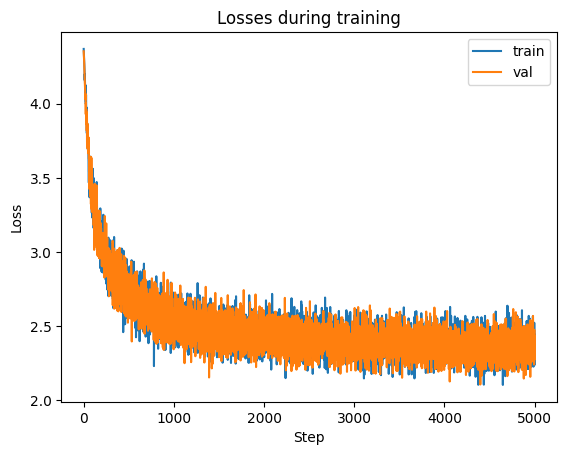

In [ ]:
# CONFIGURATION
batch_size = 32
max_context_len = 8
max_iters = 5000
learning_rate = 1e1/5

# INTIALIZE THE EMBEDDING TABLE
embedding_table = jnp.zeros((ALPHABET_SIZE, ALPHABET_SIZE))
embedding_table = wrap(embedding_table, "alphabet", "alphabet_out")

# DEFINE THE TRAINING STEP
@jax.jit
def train_step(params, input_tokens, target_tokens, learning_rate):
    # Compute loss and gradients
    loss, grads = jax.value_and_grad(empirical_risk)(params, input_tokens, target_tokens)
    # Update parameters using gradient descent
    params = params - learning_rate * grads
    return params, loss

train_losses = []
val_losses = []
for iter in tqdm(range(max_iters)):
    # Get a batch of data
    input_tokens, target_tokens = get_batch(batch_size, max_context_len, "train")

    # Wrap the tokens into named arrays
    input_tokens = wrap(input_tokens).tag("batch", "seq")
    target_tokens = wrap(target_tokens).tag("batch", "seq")

    # update parameters
    embedding_table, loss = train_step(embedding_table, input_tokens, target_tokens, learning_rate)

    # Track training loss
    train_losses.append(loss)

    # Measure validation loss
    input_tokens, target_tokens = get_batch(batch_size, max_context_len, "val")
    input_tokens = wrap(input_tokens).tag("batch", "seq")
    target_tokens = wrap(target_tokens).tag("batch", "seq")
    val_losses.append(empirical_risk(embedding_table, input_tokens, target_tokens))

# Plot training curve
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Losses during training')
plt.show()

In [ ]:
# Let's see inspect what we learned
# First, get some common contexts
input_tokens = wrap(np.array([ENCODE("an"),
                              ENCODE("th")]), "batch", "seq")

# Compute the prediction for the next tokens
log_preds = get_log_predictions(embedding_table, input_tokens)

# get the most likely next token under our model
most_likely_next_tokens = log_preds.untag("alphabet").argmax() # named axes {"batch", "seq"}

# focus on the last time step, i.e., the most likely next token after the two
# character context.

# most likely next token after "an"
y0 = itoc[most_likely_next_tokens[{"batch" : 0, "seq" : -1}].unwrap().tolist()]
print(f"Our model thinks `an' is most likely to be followed by {y0}")

# most likely next token after "th"
y1 = itoc[most_likely_next_tokens[{"batch" : 1, "seq" : -1}].unwrap().tolist()]
print(f"Our model thinks `th' is most likely to be followed by {y1}")

Our model thinks `an' is most likely to be followed by d
Our model thinks `th' is most likely to be followed by e


## Transformers

We want our predictors to depend not just on the current token, but on the entire context window that is available to them. Transformers, introduced in their modern instantiation by [(Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762), are a modern architecture that accomplishes that. Transformers are very flexible models that can represent very complex functions of the context window.

We will build them up, bit by bit, focusing on their key components: attention, residual connections, layer norm, multilayer perceptrons (MLPs).

At a very high-level, the Transformer uses these elements and
* **starts with an embedding tensor with axes {"batch", "seq", "embed"},**
* **and alternates:**
  * **communicating information between token embeddings along the "seq" axis using attention**
  * **transforming the embeddings independently with non-linear computations**


### Transforming embeddings with non-linear computations

The most common non-linear computations used in the Transformer architecture are multilayer perceptrons (a.k.a. fully-connected neural networks). The building block of MLPs is the parametric affine transformation.

For $x \in \mathbb{R}^n$, the affine transformation is

$$W x + b$$

for $W \in \mathbb{R}^{m \times n}$ and $b \in \mathbb{R}^m$.

In [ ]:
# This is how you compute an affine transformation with named axes
def affine_along(params, x, feature_axis):
    # Unpack the parameters
    W = params["W"]
    b = params["b"]
    # We use the convention that linear layers applied
    # to feature_axis have named axes
    # {feature_axis+ "_in", feature_axis+ "_out"} and

    # Apply linear transformation by taking the dot of the feature axis
    nmap_dot = nmap(jnp.dot)
    out = nmap_dot(
        W.untag(feature_axis+ "_in"),
        x.untag(feature_axis),
    )
    out = out + b # add bias which we assume has named axis {feature_axis + "_out"}

    # We use the convention that we do not rename the feature_axis
    # of the embeddings, so we have to rename the axis on its way out
    out = out.untag(feature_axis+"_out").tag(feature_axis)
    return out

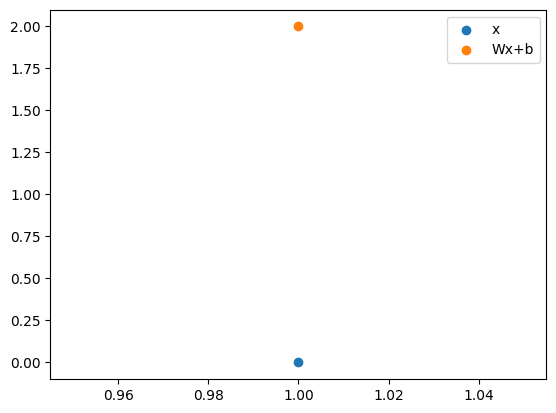

In [ ]:
theta = np.pi/2 # 90 degree rotation
params = {
    "W" : wrap(jnp.array([[np.cos(theta), -np.sin(theta)],
                          [np.sin(theta),  np.cos(theta)]]), "n_out", "n_in"),
    "b" : wrap(jnp.array([1.0, 1.0]), "n_out") # diagonal translation
}
# should be [1, 2]
x = np.array([1.0, 0.0])
y = affine_along(params, wrap(x, "n"), "n").unwrap("n")
plt.scatter(x[0], x[1], label="x")
plt.scatter(y[0], y[1], label="Wx+b")
plt.legend()

The MLP composes affine transformations and element-wise non-linearities.

*  MLPs can approximate any continuous function of the feature axis arbitrarily well (if we make them big enough), see, *e.g.*, [this review](https://pinkus.net.technion.ac.il/files/2021/02/acta.pdf).
* This is what we call **expressivity** and it means that we can use MLPs to compute complex functions of token embeddings, in principle
* When applied in practice, they are applied independently over the other batch and seq axes

In [ ]:
def mlp_along(params, x, feature_axis):
  """Applies a two-layer feed-forward network with ReLU non-linearity along the feature axis."""
  x = affine_along(params["fc1"], x, feature_axis)
  nrelu = nmap(jax.nn.relu)
  x = nrelu(x) # element-wise non-linearity called ReLU
  x = affine_along(params["fc2"], x, feature_axis)
  return x

### Communicating information between token embeddings with attention

Attention is arguably the defining feature of the Transformer architecture.

* Conceptually, one way to think about attention is as a communication mechanism that allows tokens to communicate with each other
* Mechanistically, a good way to think about attention is as a **continuous dictionary look-up**

Let's build up attention step-by-step.


#### Attention - V0

What do we mean by dictionary look-up? Consider the following.

In [ ]:
# This is a dictionary with three (key, value) pairs
dictionary = {
  0 : 1,
  1 : 0,
  3 : 1,
}
# Looking up a query involves finding the matching key and returning its value
query = 1
print(f"query={query} matches with key={query} and has value={dictionary[query]}.")

query=1 matches with key=1 and has value=0.


The following code implements this exact same dictionary in JAX with Penzai's named axis system. This is the most rudimentary form of attention.

In [ ]:
# First, let's represent integers using the standard basis
keys = wrap(
  np.array([[1,0,0,0],
            [0,1,0,0],
            [0,0,0,1]]), "key", "embed")

values = wrap(
  np.array([[0,1,0,0],
            [1,0,0,0],
            [0,1,0,0]]), "key", "embed")

query = wrap(np.array([0, 1, 0, 0]), "embed")

In [ ]:
def attention_v0(query, keys, values):
  # The key that is aligned with the query will have an inner product of 1
  # in embedding space. Every other inner product will be 0.

  # So, we can compute the index of the corresponding key by checking
  # the alignment of each key with the query. Let's call this index
  nmap_dot = nmap(jnp.dot)
  index = nmap_dot(query.untag("embed"), keys.untag("embed"))

  # Taking the inner product along the key axis with the index
  return nmap_dot(index.untag("key"), values.untag("key"))

In [ ]:
print("This is attention V0:\n")
print(f"query={query.unwrap('embed')} matches with key={query.unwrap('embed')} and has value={attention_v0(query, keys, values).unwrap('embed')}.")
dictdecode = lambda x: int(nmap(jnp.argmax)(x.untag("embed")))
print("After decoding...")
print(f"query={dictdecode(query)} matches with key={dictdecode(query)} and has value={dictdecode(attention_v0(query, keys, values))}.")
print("\nSame as the dictionary!")

This is attention V0:

query=[0 1 0 0] matches with key=[0 1 0 0] and has value=[1 0 0 0].
After decoding...
query=1 matches with key=1 and has value=0.

Same as the dictionary!


#### Attention - V1

* The lookup function we just wrote is a special case of attention! So attention generalizes dictionaries.
* The key features of attention are:
  * Look up for multiple queries at once, in paralell
  * General floating-point embeddings to represent keys, values, and queries
  * 'soft' lookups using softmax distributions, instead of the 'hard' lookup that we just
  implemented
* **These features allow attention to perform as a soft, learnable dictionary lookup.**
Let's implement this.

In [ ]:
def attention_v1(queries, keys, values):
  # queries named axes include {"query", "embed"} and it is a floating-point array
  # keys named axes include {"key", "embed"} and it is a floating-point array
  # values named axes include {"key", "embed"} and it is a floating-point array

  # Compute scores by taking the inner product of every key with every query
  # This checks "alignment".
  nmap_dot = nmap(jnp.dot)
  scores = nmap_dot(queries.untag("embed"), keys.untag("embed"))

  # Compute a probability distribution over keys for each query
  # This is the "soft" index, aka attention!
  nmap_softmax = nmap(jax.nn.softmax)
  attn_dist = nmap_softmax(scores.untag("key"))
  attn_dist = attn_dist.tag("key")

  # Taking the inner product along the key axis with the attention distribution
  # returns the average value, with each key contributing in proportion to
  # its attention weight
  return nmap_dot(attn_dist.untag("key"), values.untag("key"))

In [ ]:
with np.printoptions(precision=2, suppress=True):
  print("This is attention V1:")
  print(f"query={query.unwrap('embed')} has value={np.round(attention_v1(query, keys, values).unwrap('embed'),2)}.")

This is attention V1:
query=[0 1 0 0] has value=[0.58 0.42 0.   0.  ].


#### Attention - V2

The softmax can very quickly saturate as the dimensionality of the keys and queries grows.

In [ ]:
with np.printoptions(precision=2, suppress=True):
  for dim in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    query = wrap(np.random.randn(dim)).tag("embed")
    keys = wrap(np.random.randn(3, dim)).tag("key", "embed")
    print(f"dim={dim} value={np.round(attention_v1(query, keys, values).unwrap('embed'), 2)}")

dim=1 value=[0.02 0.98 0.   0.  ]
dim=2 value=[0.32 0.68 0.   0.  ]
dim=4 value=[0.93 0.07 0.   0.  ]
dim=8 value=[0.79 0.21 0.   0.  ]
dim=16 value=[0. 1. 0. 0.]
dim=32 value=[0.07 0.93 0.   0.  ]
dim=64 value=[0.95 0.05 0.   0.  ]
dim=128 value=[0. 1. 0. 0.]
dim=256 value=[0. 1. 0. 0.]
dim=512 value=[1. 0. 0. 0.]
dim=1024 value=[1. 0. 0. 0.]


One way to mitigate this is to divide the queries by the square root of the dimensionality of the features

In [ ]:
with np.printoptions(precision=2, suppress=True):
  for dim in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    query = wrap(np.random.randn(dim)/np.sqrt(dim)).tag("embed")
    keys = wrap(np.random.randn(3, dim)).tag("key", "embed")
    print(f"dim={dim} value={np.round(attention_v1(query, keys, values).unwrap('embed'), 2)}")

dim=1 value=[0.21 0.79 0.   0.  ]
dim=2 value=[0.32 0.68 0.   0.  ]
dim=4 value=[0.28 0.72 0.   0.  ]
dim=8 value=[0.37 0.63 0.   0.  ]
dim=16 value=[0.47 0.53 0.   0.  ]
dim=32 value=[0.75 0.25 0.   0.  ]
dim=64 value=[0.31 0.69 0.   0.  ]
dim=128 value=[0.21 0.79 0.   0.  ]
dim=256 value=[0.1 0.9 0.  0. ]
dim=512 value=[0.54 0.46 0.   0.  ]
dim=1024 value=[0.82 0.18 0.   0.  ]


Which leads us to attention V2:

In [ ]:
def attention_v2(queries, keys, values):
  # queries named axes include {"query", "embed"}
  # keys named axes include {"key", "embed"}
  # values named axes include {"key", "embed"}

  # Compute scores by taking the inner product of every key with every query
  # This checks "alignment".
  nmap_dot = nmap(jnp.dot)
  scores = nmap_dot(queries.untag("embed"), keys.untag("embed"))

  # Scale the attention logits to avoid saturating the softmax
  feature_dim = queries.named_shape["embed"]
  scores = scores / np.sqrt(feature_dim)

  # Compute a probability distribution over keys for each query
  # This is the "soft" index, aka attention!
  nmap_softmax = nmap(jax.nn.softmax)
  attn_dist = nmap_softmax(scores.untag("key"))
  attn_dist = attn_dist.tag("key")

  # Taking the inner product along the key axis with the attention distribution
  # returns the average value, with each key contributing in proportion to
  # its attention weight
  # the output will have named axes {"query", "embed"} and is a floating-point array
  return nmap_dot(attn_dist.untag("key"), values.untag("key"))

#### Self-Attention

In many applications, the key and query axis are the same. In this case, we call it "self-attention". Transformers use self-attention!

* Let's say we're training on an input sequence $X = (x_0, \ldots, x_{T-1})$ with output sequence $Y = (x_1, \ldots, x_{T})$
* We want to condition on an entire context window when predicting $x_{i+1}$
* To do this, we want to pass information between tokens in a context window
* We do this with attention!
* In particular, within a context window, we will let every token take on the role of both a key and a query
* This is called *self-attention*
* Self-attention takes the current embedding of the tokens and produces the keys, queries, and values of attention from separate linear functions
* By some conventions, it also applies an affine map as an output

Let's see what this looks like


In [ ]:
def selfattention(params, emb):
  # params["Wq"] named axes are {"embed", "embed"}
  # params["Wk"] named axes are {"embed", "embed"}
  # params["Wv"] named axes are {"embed", "embed"}
  # params["aff"]["W"] named axes are {"embed_in", "embed_out"}
  # params["aff"]["b"] named axes are {"embed_out"}
  # emb named axes include {"seq", "embed"}

  # Apply three linear maps to the embeddings independently across "seq"
  # These are now our keys and queries and values for self-attention!
  queries = nmap(jnp.dot)(params["Wq"].untag("embed"), emb.untag("embed"))
  keys = nmap(jnp.dot)(params["Wk"].untag("embed"), emb.untag("embed"))
  values = nmap(jnp.dot)(params["Wv"].untag("embed"), emb.untag("embed"))

  # As this is SELF-attention, the queries and keys both have the same dimension "seq".
  # But, we want (key, query) pairs to interact, even if the key and query index
  # is different. To accomplish this with the named array system, we need to rename
  # the "seq" axis for both.
  queries = queries.untag("seq").tag("query")
  keys = keys.untag("seq").tag("key")
  values = values.untag("seq").tag("key")

  # Compute scores by taking the inner product of every key with every query
  # This checks "alignment".
  nmap_dot = nmap(jnp.dot)
  scores = nmap_dot(queries.untag("embed"), keys.untag("embed"))

  # Scale the attention logits to avoid saturating the softmax
  feature_dim = queries.named_shape["embed"]
  scores = scores / np.sqrt(feature_dim)

  # Compute a probability distribution over keys for each query
  # This is the "soft" index, aka attention!
  nmap_softmax = nmap(jax.nn.softmax)
  attn_dist = nmap_softmax(scores.untag("key"))
  attn_dist = attn_dist.tag("key")

  # Taking the inner product along the key axis with the attention distribution
  # returns the average value, with each key contributing in proportion to
  # its attention weight
  # the output will have named axes {"query", "embed"} and is a floating-point array
  emb = nmap_dot(attn_dist.untag("key"), values.untag("key"))

  # We're going to rearrange the dimensions now to bring us back to convention.
  # First, we rename "query", which was a holdover from our attention convention
  emb = emb.untag("query").tag("seq")
  # emb named axes should now include {"seq", "embed"}

  # Final affine layer
  emb = affine_along(params["aff"], emb, "embed")
  return emb

#### Multi-headed Self-attention

* We often want to let the network model different types of interactions between tokens
* At the moment, the interaction is computed in the embedding dimension and we only have one of those!
* Multi-headed attention addresses this by splitting the embedding dimension into what are called "heads" and computing self-attention independently across heads

This is very easily implemented in the named axes system by changing the shape of the parameters. Most of the code stays the same!!

In [ ]:
def multiheaded_selfattention(params, emb):
  # !!------------ THIS BIT CHANGES --------------!!
  # params["Wq"] named axes are {"embed", "head", "embed/head"} where dim("head") * dim ("embed/head") = dim("embed")
  # params["Wk"] named axes are {"embed", "head", "embed/head"} where dim("head") * dim ("embed/head") = dim("embed")
  # params["Wv"] named axes are {"embed", "head", "embed/head"} where dim("head") * dim ("embed/head") = dim("embed")

  # dim("head") is the number of heads
  # dim("embed/head") is the dimensionality of the embeddings per head

  # !!------------ THIS BIT DOESN'T --------------!!
  # params["aff"]["W"] named axes are {"embed_in", "embed_out"}
  # params["aff"]["b"] named axes are {"embed_out"}
  # emb named axes include {"seq", "embed"}

  # Apply three linear maps to the embeddings independently across "seq"
  # These are now our keys and queries and values for self-attention!
  queries = nmap(jnp.dot)(params["Wq"].untag("embed"), emb.untag("embed"))
  keys = nmap(jnp.dot)(params["Wk"].untag("embed"), emb.untag("embed"))
  values = nmap(jnp.dot)(params["Wv"].untag("embed"), emb.untag("embed"))

  # As this is SELF-attention, the queries and keys both have the same dimension "seq".
  # But, we want (key, query) pairs to interact, even if the key and query index
  # is different. To accomplish this with the named array system, we need to rename
  # the "seq" axis for both.
  queries = queries.untag("seq").tag("query")
  keys = keys.untag("seq").tag("key")
  values = values.untag("seq").tag("key")

  # !!------------ THIS BIT CHANGES --------------!!
  # Compute scores by taking the inner product of every key with every query
  # This checks "alignment".
  nmap_dot = nmap(jnp.dot)
  scores = nmap_dot(queries.untag("embed/head"), keys.untag("embed/head"))

  # Scale the attention logits to avoid saturating the softmax
  feature_dim = queries.named_shape["embed/head"]
  scores = scores / np.sqrt(feature_dim)

  # !!------------ THIS BIT DOESN'T --------------!!
  # Compute a probability distribution over keys for each query
  # This is the "soft" index, aka attention!
  nmap_softmax = nmap(jax.nn.softmax)
  attn_dist = nmap_softmax(scores.untag("key"))
  attn_dist = attn_dist.tag("key")

  # Taking the inner product along the key axis with the attention distribution
  # returns the average value, with each key contributing in proportion to
  # its attention weight
  # the output will have named axes {"query", "embed"} and is a floating-point array
  emb = nmap_dot(attn_dist.untag("key"), values.untag("key"))


  # We're going to rearrange the dimensions now to bring us back to convention.
  # First, we rename "query", which was a holdover from our attention convention
  emb = emb.untag("query").tag("seq")

  # !!------------ THIS BIT CHANGES --------------!!
  # emb named axes should now include {"seq", "head", "embed/head"}
  # We can concatenate "head" and "embed/head" axes by reshaping:
  emb = emb.untag("head", "embed/head").flatten().tag("embed")

  # emb named axes should now include {"seq", "embed"}

  # Final affine layer
  emb = affine_along(params["aff"], emb, "embed")
  return emb

#### Causal Masking

There's a problem, though.

* The next token $y_i$ that we're trying to predict is also present in the input, except for the very last, next token $y_{T-1}$
* If the Transformer is shown $x_{i+1}$ as part of the input, it could just copy $x_{i+1}$ in its prediction and ignore the context $x_0 \ldots x_{i}$
  * more formally, the probability distribution $p(x_{i+1} | x_0, \ldots, x_T)$ has zero entropy for all $i = 0, \ldots, T-1$
* This is not the distribution we set out to model!
* The way to force the transformer to learn the distribution $p(x_{i+1} | x_0, \ldots, x_{i})$ that we want is to *mask* the input tokens appropriately
* In particular, when predicting $x_{i+1}$, we only allow tokens $x_j$ with $j \leq i$ to communicate via attention.
* In practice, this is accomplished by making sure that the embedding at time $i$ can only depend on embeddings at times $j \leq i$
* This is called *causal masking* because it prevents predictions from "seeing" the future

Let's see what this looks like in code

In [ ]:
def multiheaded_selfattention(params, emb, causal=True):
  # params["Wq"] named axes are {"embed", "head", "embed/head"} where dim("head") * dim ("embed/head") = dim("embed")
  # params["Wk"] named axes are {"embed", "head", "embed/head"} where dim("head") * dim ("embed/head") = dim("embed")
  # params["Wv"] named axes are {"embed", "head", "embed/head"} where dim("head") * dim ("embed/head") = dim("embed")

  # dim("head") is the number of heads
  # dim("embed/head") is the dimensionality of the embeddings per head

  # params["aff"]["W"] named axes are {"embed_in", "embed_out"}
  # params["aff"]["b"] named axes are {"embed_out"}
  # emb named axes include {"seq", "embed"}

  # Apply three linear maps to the embeddings independently across "seq"
  # These are now our keys and queries and values for self-attention!
  queries = nmap(jnp.dot)(params["Wq"].untag("embed"), emb.untag("embed"))
  keys = nmap(jnp.dot)(params["Wk"].untag("embed"), emb.untag("embed"))
  values = nmap(jnp.dot)(params["Wv"].untag("embed"), emb.untag("embed"))

  # As this is SELF-attention, the queries and keys both have the same dimension "seq".
  # But, we want (key, query) pairs to interact, even if the key and query index
  # is different. To accomplish this with the named array system, we need to rename
  # the "seq" axis for both.
  queries = queries.untag("seq").tag("query")
  keys = keys.untag("seq").tag("key")
  values = values.untag("seq").tag("key")

  # Compute scores by taking the inner product of every key with every query
  # This checks "alignment".
  nmap_dot = nmap(jnp.dot)
  scores = nmap_dot(queries.untag("embed/head"), keys.untag("embed/head"))

  # Scale the attention logits to avoid saturating the softmax
  feature_dim = queries.named_shape["embed/head"]
  scores = scores / np.sqrt(feature_dim)

  if causal:
    # For causal attention, we want to mask out (set to -inf) any (key, query) pair
    # such that key's index is greater than query's index, i.e., key is in the future.
    # This ensures the softmax will give zero probability to attending to the future.

    # Get the sequence indices for the queries and keys to enable causal masking
    query_dim = queries.named_shape["query"]
    key_dim = keys.named_shape["key"]
    k_idxs = pz.nx.arange("key", key_dim)
    q_idxs = pz.nx.arange("query", query_dim)

    # Set the scores to -inf where q < k
    nmap_where = nmap(jnp.where)
    scores = nmap_where(
      q_idxs < k_idxs,  # Broadcasts across other dimensions
      float('-inf'),
      scores,
    )

  # Compute a probability distribution over keys for each query
  # This is the "soft" index, aka attention!
  nmap_softmax = nmap(jax.nn.softmax)
  attn_dist = nmap_softmax(jax.nn.softmax)(scores.untag("key"))
  attn_dist = attn_dist.tag("key")

  # Taking the inner product along the key axis with the attention distribution
  # returns the average value, with each key contributing in proportion to
  # its attention weight
  # the output will have named axes {"query", "embed"} and is a floating-point array
  emb = nmap_dot(attn_dist.untag("key"), values.untag("key"))


  # We're going to rearrange the dimensions now to bring us back to convention.
  # First, we rename "query", which was a holdover from our attention convention
  emb = emb.untag("query").tag("seq")

  # emb named axes should now include {"seq", "head", "embed/head"}
  # We can concatenate "head" and "embed/head" axes by reshaping:
  emb = emb.untag("head", "embed/head").flatten().tag("embed")

  # emb named axes should now include {"seq", "embed"}

  # Final affine layer
  emb = affine_along(params["aff"], emb, "embed")
  return emb

This is the famous multi-headed self-attention with causal masking!

#### Positional embeddings

There's a problem, though.

* Dictionaries do not have an order
* Similarly, attention is *permutation invariant*, i.e., the embeddings that attention computs do not depend on the order of the keys
* This is a problem because the order of tokens will very likely tell us something about the next token!
* Positional embeddings are one way of addressing that for next-token prediction
* This is a large area of study, but we will use the simplest approach:
  * Create an embedding parameter for each index along the time axis
  * Add the positional embedding for index $i$ to the input token embedding for token $x_i$
  * Train the positional embeddings

This is what that looks like

In [ ]:
tokens = wrap(np.random.randint(10, size=(1, 5)), "batch", "seq")

# One embedding for every possible token 0, ..., 9
token_embedding = wrap(np.random.randn(10, 2), "alphabet", "embed")

# One embedding for every "seq" index 0, ..., 4
position_embedding = wrap(np.random.randn(5, 2), "seq", "embed")

# Token and position embeddings
seq_len = tokens.named_shape["seq"]
tok_emb = token_embedding[{"alphabet" : tokens}] # embed tokens
pos_emb = position_embedding[{"seq" : pz.nx.arange("seq", seq_len)}] # embed indices

# This is the embedding we will pass to the Transformer
emb = tok_emb + pos_emb
{
    "tok_emb" : tok_emb,
    "pos_emb" : pos_emb,
    "emb" : emb,
}

{'tok_emb': <NamedArray float32(| embed:2, batch:1, seq:5) ≈0.033 ±0.94 [≥-2.0, ≤1.4] nonzero:10 (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: GPU 0>,
 'pos_emb': <NamedArray float32(| embed:2, seq:5) ≈0.17 ±1.0 [≥-1.8, ≤1.7] nonzero:10 (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: GPU 0>,
 'emb': <NamedArray float32(| embed:2, batch:1, seq:5) ≈0.21 ±1.2 [≥-2.0, ≤1.9] nonzero:10 (wrapping jax.Array)
   <Arrayviz rendering>
 | Device: GPU 0>}

### Overcoming the challenge of depth

As neural networks get deeper, their non-linearities make optimization challenging. This is due to a number of reasons, but intuitively this occurs because (i) information gets lost in non-invertible functions and (ii) randomly initialized neural networks tend to be non-invertible. This is a huge topic of inquiry and Transformers use two tricks to mitigate this.

* **[Layer norm](https://arxiv.org/abs/1607.06450).** Layer norm renormalizes every dimension along the "embed" axis independently and has a learnable scale and bias.

* **[Residual connections](https://arxiv.org/abs/1512.03385).** Residual connections help stabilize learning for very deep MLPs and neural networks. They allow information to skip directly from earlier layers to later ones. They are very simple to define: if we are applying layer $f : \mathbb{R}^d \to \mathbb{R}^d$ to an input $x \in \mathbb{R}^d$, the residual connection layer is $y = x + f(x)$. We will see this in action in the final Transformer block implementation.

We don't have time to cover these in the class, so I encourage you to check out the GitHub.

# GitHub
Debugging notebooks is very time-consuming. So, I don't want to run the full Transformer in a notebook.

Let's go see the associated [GitHub](https://github.com/cmaddis/tlm) to see what this all looks like in code!
